<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Natural Language Processing</h1>
<h1>Sequence Modeling</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gzip
from collections import Counter
from pprint import pprint
import time

import random

import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm
tqdm.pandas()

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

import torch
torch.manual_seed(RANDOM_SEED)

import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchview
from torchview import draw_graph

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.10.18
IPython version      : 8.38.0

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: e080700e51545c1a6b5ca0b196383d0333f2e23b

numpy     : 1.26.4
torch     : 2.3.1
watermark : 2.4.3
pandas    : 2.3.3
matplotlib: 3.10.8
torchview : 0.2.7



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load the Dataset

Define helper classes for vocabulary and dataset

In [4]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<unk>": 1}
        self.idx2word = {0: "<pad>", 1: "<unk>"}
        self.word_counts = Counter()
        
    def build_vocab(self, texts, max_size=None):
        """Build vocabulary from texts"""
        for text in texts:
            tokens = text.lower().split()
            self.word_counts.update(tokens)
        
        # Get most common words
        if max_size:
            most_common = self.word_counts.most_common(max_size - 2)  # -2 for <pad> and <unk>
        else:
            most_common = self.word_counts.most_common()
        
        # Add to vocabulary
        for idx, (word, count) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word
    
    def encode(self, text):
        """Convert text to indices"""
        tokens = text.lower().split()
        return [self.word2idx.get(token, 1) for token in tokens]  # 1 is <unk>
    
    def __len__(self):
        return len(self.word2idx)


class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab=None):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        if self.vocab:
            text_indices = self.vocab.encode(text)
        else:
            text_indices = text
            
        return torch.tensor(text_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)


def collate_batch(batch):
    """Collate function for DataLoader to handle variable length sequences"""
    texts, labels = zip(*batch)
    
    # Pad sequences
    texts_padded = pad_sequence(texts, batch_first=False, padding_value=0)  # batch_first=False for RNN
    labels = torch.stack(labels)
    
    return texts_padded, labels

Load the IMDB dataset

In [5]:
# Load dataset
df = pd.read_csv('data/IMDB Dataset.csv')

# Convert labels to numeric (0 = negative, 1 = positive)
label_map = {'negative': 0, 'positive': 1}
df['label'] = df['sentiment'].map(label_map)

print(f'Dataset size: {len(df)}')
print(f'Sample data:\n{df.head()}')

Dataset size: 50000
Sample data:
                                              review sentiment  label
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative      0
4  Petter Mattei's "Love in the Time of Money" is...  positive      1


Split the dataset into training, validation, and test partitions:

In [6]:
# Split the dataset
from sklearn.model_selection import train_test_split

# First split: 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['review'].values, 
    df['label'].values, 
    test_size=0.2, 
    random_state=RANDOM_SEED,
    stratify=df['label']
)

# Second split: 85% train, 15% validation (of the train+val set)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=0.15, 
    random_state=RANDOM_SEED,
    stratify=y_train_val
)

In [7]:
print('Shape of training data:', len(X_train))
print('Shape of test data:', len(X_test))
print('Shape of validation data:', len(X_validation))

Shape of training data: 34000
Shape of test data: 10000
Shape of validation data: 6000


## Build Vocabulary

Build the vocabulary based on the top "vocabulary_size" words:

In [8]:
vocabulary_size = 20_000

In [9]:
# Build vocabulary
TEXT_vocab = Vocabulary()
TEXT_vocab.build_vocab(X_train, max_size=vocabulary_size)

print(f'Vocabulary size: {len(TEXT_vocab)}')
print(f'Number of classes: 2')

Vocabulary size: 20000
Number of classes: 2


## Define Data Loaders

In [10]:
batch_size = 128

# Check for available device (MPS for Apple Silicon, CUDA for NVIDIA, CPU otherwise)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: mps


In [11]:
# Create datasets
train_dataset = TextDataset(X_train, y_train, TEXT_vocab)
valid_dataset = TextDataset(X_validation, y_validation, TEXT_vocab)
test_dataset = TextDataset(X_test, y_test, TEXT_vocab)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_batch
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_batch
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_batch
)

Finally, we are ready to define our models

# Simple RNN model

As the structure of the model is the same for RNN, GRU, and LSTMs, we implement just one of them for demonstration purposes. We can easily plugin another type of layer as needed

In [12]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_size, hidden_size, output_size):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size)        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, text):        
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden.squeeze_(0)        
        output = self.fc(hidden)
        
        return output

In [13]:
embedding_size = 128
hidden_size = 256
num_classes = 2

In [14]:
model = RNN(len(TEXT_vocab),  # vocabulary size
            embedding_size,
            hidden_size,
            num_classes 
           )

In [15]:
print(model)

RNN(
  (embedding): Embedding(20000, 128)
  (rnn): LSTM(128, 256)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [16]:
learning_rate = 0.005
n_epochs = 15

In [17]:
model = model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

## Training

In [18]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for features, targets in data_loader:

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            loss = F.cross_entropy(logits, targets)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            
    return correct_pred.float()/num_examples * 100, loss

Based on this [notebook](https://github.com/rasbt/stat453-deep-learning-ss21/tree/main/L15)

In [19]:
start_time = time.time()

history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epochs': n_epochs
    }

for epoch in range(n_epochs):
    model.train()
    model.to(device)
    for batch_idx, (text, labels) in tqdm(enumerate(train_loader), 
                                      total=len(train_loader), 
                                      desc='Epoch: %u' % (epoch+1),
                                      leave=True):
        
        text = text.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(text)
        
        # Back propagation
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        
        # update weights
        optimizer.step()
        
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{n_epochs:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, device)[0]:.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, device)[0]:.2f}%')
    
    history['train_loss'].append(loss.to('cpu').detach().numpy())
    history['train_acc'].append(compute_accuracy(model, train_loader, device)[0].to('cpu').detach().numpy())
    
    val_acc, val_loss = compute_accuracy(model, valid_loader, device)
    
    history['val_acc'].append(val_acc.to('cpu').detach().numpy())
    history['val_loss'].append(val_loss.to('cpu').detach().numpy())

    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, device)[0]:.2f}%')

Epoch: 1:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 001/015 | Batch 000/266 | Loss: 0.6930
Epoch: 001/015 | Batch 050/266 | Loss: 0.6895
Epoch: 001/015 | Batch 100/266 | Loss: 0.6935
Epoch: 001/015 | Batch 150/266 | Loss: 0.6884
Epoch: 001/015 | Batch 200/266 | Loss: 0.6938
Epoch: 001/015 | Batch 250/266 | Loss: 0.6923
training accuracy: 50.11%
valid accuracy: 50.03%
Time elapsed: 0.80 min


Epoch: 2:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 002/015 | Batch 000/266 | Loss: 0.6941
Epoch: 002/015 | Batch 050/266 | Loss: 0.6921
Epoch: 002/015 | Batch 100/266 | Loss: 0.6928
Epoch: 002/015 | Batch 150/266 | Loss: 0.6950
Epoch: 002/015 | Batch 200/266 | Loss: 0.6909
Epoch: 002/015 | Batch 250/266 | Loss: 0.6900
training accuracy: 50.22%
valid accuracy: 50.03%
Time elapsed: 1.57 min


Epoch: 3:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 003/015 | Batch 000/266 | Loss: 0.6935
Epoch: 003/015 | Batch 050/266 | Loss: 0.6887
Epoch: 003/015 | Batch 100/266 | Loss: 0.6889
Epoch: 003/015 | Batch 150/266 | Loss: 0.6917
Epoch: 003/015 | Batch 200/266 | Loss: 0.6959
Epoch: 003/015 | Batch 250/266 | Loss: 0.6973
training accuracy: 50.17%
valid accuracy: 49.98%
Time elapsed: 2.54 min


Epoch: 4:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 004/015 | Batch 000/266 | Loss: 0.6900
Epoch: 004/015 | Batch 050/266 | Loss: 0.6881
Epoch: 004/015 | Batch 100/266 | Loss: 0.6879
Epoch: 004/015 | Batch 150/266 | Loss: 0.6869
Epoch: 004/015 | Batch 200/266 | Loss: 0.6908
Epoch: 004/015 | Batch 250/266 | Loss: 0.6876
training accuracy: 50.25%
valid accuracy: 50.00%
Time elapsed: 3.59 min


Epoch: 5:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 005/015 | Batch 000/266 | Loss: 0.6940
Epoch: 005/015 | Batch 050/266 | Loss: 0.6883
Epoch: 005/015 | Batch 100/266 | Loss: 0.6903
Epoch: 005/015 | Batch 150/266 | Loss: 0.6939
Epoch: 005/015 | Batch 200/266 | Loss: 0.6902
Epoch: 005/015 | Batch 250/266 | Loss: 0.6894
training accuracy: 50.34%
valid accuracy: 50.07%
Time elapsed: 4.60 min


Epoch: 6:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 006/015 | Batch 000/266 | Loss: 0.6919
Epoch: 006/015 | Batch 050/266 | Loss: 0.6938
Epoch: 006/015 | Batch 100/266 | Loss: 0.6899
Epoch: 006/015 | Batch 150/266 | Loss: 0.6899
Epoch: 006/015 | Batch 200/266 | Loss: 0.6907
Epoch: 006/015 | Batch 250/266 | Loss: 0.6901
training accuracy: 50.27%
valid accuracy: 50.00%
Time elapsed: 5.52 min


Epoch: 7:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 007/015 | Batch 000/266 | Loss: 0.6918
Epoch: 007/015 | Batch 050/266 | Loss: 0.6909
Epoch: 007/015 | Batch 100/266 | Loss: 0.6883
Epoch: 007/015 | Batch 150/266 | Loss: 0.6903
Epoch: 007/015 | Batch 200/266 | Loss: 0.6898
Epoch: 007/015 | Batch 250/266 | Loss: 0.6641
training accuracy: 67.19%
valid accuracy: 64.07%
Time elapsed: 6.48 min


Epoch: 8:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 008/015 | Batch 000/266 | Loss: 0.5937
Epoch: 008/015 | Batch 050/266 | Loss: 0.6274
Epoch: 008/015 | Batch 100/266 | Loss: 0.6152
Epoch: 008/015 | Batch 150/266 | Loss: 0.4814
Epoch: 008/015 | Batch 200/266 | Loss: 0.4749
Epoch: 008/015 | Batch 250/266 | Loss: 0.4091
training accuracy: 84.81%
valid accuracy: 80.37%
Time elapsed: 7.48 min


Epoch: 9:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 009/015 | Batch 000/266 | Loss: 0.4381
Epoch: 009/015 | Batch 050/266 | Loss: 0.2550
Epoch: 009/015 | Batch 100/266 | Loss: 0.3505
Epoch: 009/015 | Batch 150/266 | Loss: 0.3050
Epoch: 009/015 | Batch 200/266 | Loss: 0.3110
Epoch: 009/015 | Batch 250/266 | Loss: 0.3265
training accuracy: 89.11%
valid accuracy: 83.42%
Time elapsed: 8.42 min


Epoch: 10:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 010/015 | Batch 000/266 | Loss: 0.2478
Epoch: 010/015 | Batch 050/266 | Loss: 0.2431
Epoch: 010/015 | Batch 100/266 | Loss: 0.3006
Epoch: 010/015 | Batch 150/266 | Loss: 0.2818
Epoch: 010/015 | Batch 200/266 | Loss: 0.2744
Epoch: 010/015 | Batch 250/266 | Loss: 0.2230
training accuracy: 92.77%
valid accuracy: 86.00%
Time elapsed: 9.37 min


Epoch: 11:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 011/015 | Batch 000/266 | Loss: 0.1594
Epoch: 011/015 | Batch 050/266 | Loss: 0.2053
Epoch: 011/015 | Batch 100/266 | Loss: 0.1765
Epoch: 011/015 | Batch 150/266 | Loss: 0.1898
Epoch: 011/015 | Batch 200/266 | Loss: 0.1390
Epoch: 011/015 | Batch 250/266 | Loss: 0.2889
training accuracy: 94.46%
valid accuracy: 85.92%
Time elapsed: 10.29 min


Epoch: 12:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 012/015 | Batch 000/266 | Loss: 0.2068
Epoch: 012/015 | Batch 050/266 | Loss: 0.1069
Epoch: 012/015 | Batch 100/266 | Loss: 0.1610
Epoch: 012/015 | Batch 150/266 | Loss: 0.2092
Epoch: 012/015 | Batch 200/266 | Loss: 0.1290
Epoch: 012/015 | Batch 250/266 | Loss: 0.1185
training accuracy: 96.06%
valid accuracy: 86.98%
Time elapsed: 11.16 min


Epoch: 13:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 013/015 | Batch 000/266 | Loss: 0.1027
Epoch: 013/015 | Batch 050/266 | Loss: 0.1205
Epoch: 013/015 | Batch 100/266 | Loss: 0.1056
Epoch: 013/015 | Batch 150/266 | Loss: 0.2263
Epoch: 013/015 | Batch 200/266 | Loss: 0.1286
Epoch: 013/015 | Batch 250/266 | Loss: 0.1316
training accuracy: 96.97%
valid accuracy: 86.77%
Time elapsed: 11.97 min


Epoch: 14:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 014/015 | Batch 000/266 | Loss: 0.0956
Epoch: 014/015 | Batch 050/266 | Loss: 0.0622
Epoch: 014/015 | Batch 100/266 | Loss: 0.0927
Epoch: 014/015 | Batch 150/266 | Loss: 0.1080
Epoch: 014/015 | Batch 200/266 | Loss: 0.1995
Epoch: 014/015 | Batch 250/266 | Loss: 0.1855
training accuracy: 97.63%
valid accuracy: 86.67%
Time elapsed: 12.76 min


Epoch: 15:   0%|          | 0/266 [00:00<?, ?it/s]

Epoch: 015/015 | Batch 000/266 | Loss: 0.0614
Epoch: 015/015 | Batch 050/266 | Loss: 0.1336
Epoch: 015/015 | Batch 100/266 | Loss: 0.0676
Epoch: 015/015 | Batch 150/266 | Loss: 0.0395
Epoch: 015/015 | Batch 200/266 | Loss: 0.1474
Epoch: 015/015 | Batch 250/266 | Loss: 0.1834
training accuracy: 97.76%
valid accuracy: 86.92%
Time elapsed: 13.56 min
Total Training Time: 13.56 min
Test accuracy: 86.32%


In [20]:
def plot_history(history):    
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=False)
    
    epochs = range(history['epochs'])
    
    ax_lst[0].plot(epochs, history['train_loss'], label='Training')
    ax_lst[0].plot(epochs, history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(epochs)
    
    ax_lst[1].plot(epochs, history['train_acc'], label='Training')
    ax_lst[1].plot(epochs, history['val_acc'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(epochs)

    ax_lst[1].legend()
    
    fig.tight_layout()

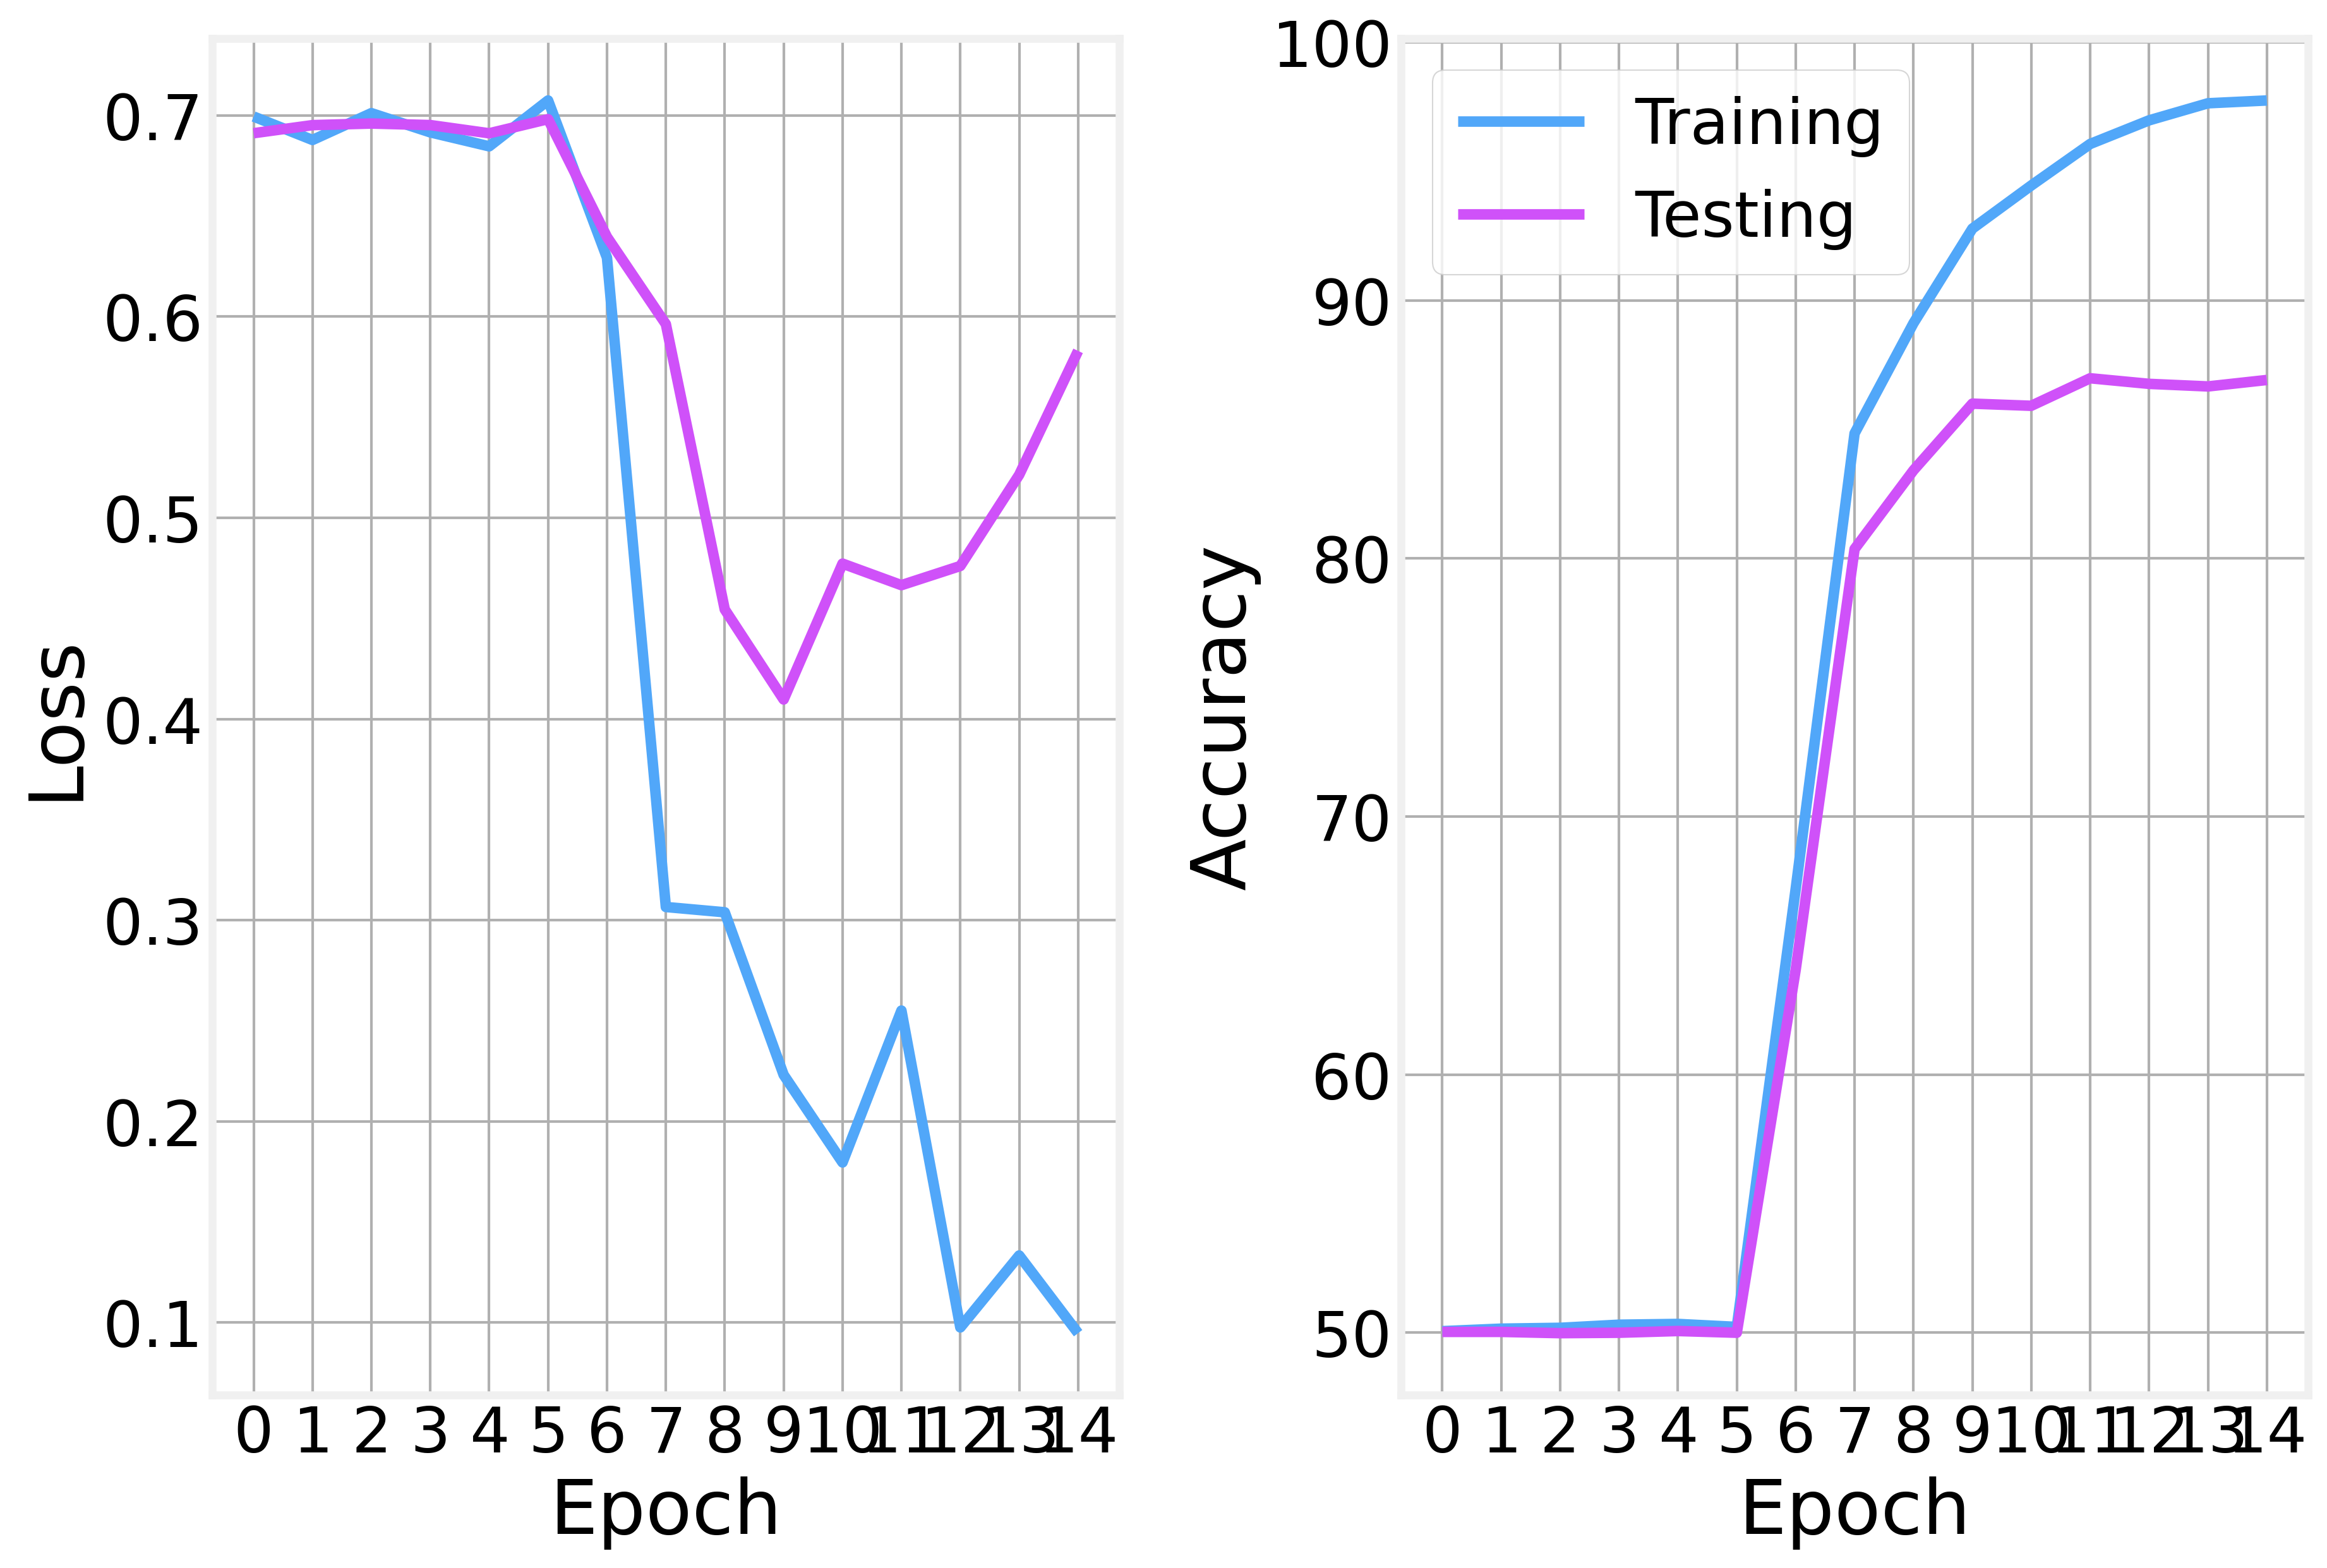

In [21]:
plot_history(history)

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>